# Оптимизация маркетинговых затрат в Яндес.Афише

Есть данные, которые содержат выгрузку визитов, заказов и статистику марткетинговых затрат Яндекс.Афиши с июня 2017 по конец мая 2018 года.
Данные находятся в соответствующих выгрузках: visits_log.csv, orders_log.csv и costs.csv.

Проанализировать:
- как люди пользуются продуктом,
- когда они начинают покупать,
- сколько денег приносит каждый клиент
- когда клиент окупается.

На основании полученных метрик дать рекомендации маркетологам какие источники/платформы следует использовать.

## Оглавление

[1. Подготовка данных к анализу](#1)
<br>[2. Анализ данных](#2)
<br>[2.1. Продукт](#21)
<br>[2.2. Продажи](#22)
<br>[2.3. Маркетинг](#23)
<br>- [Расчет LTV, CAC, ROMI для различных устройств и источников](#231)
<br>[3. Выводы](#3)

## 1. Подготовка данных к анализу <a class="anchor" id="1"></a>

In [232]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns; sns.set()

In [233]:
visit = pd.read_csv('/datasets/visits_log.csv')
order = pd.read_csv('/datasets/orders_log.csv')
cost = pd.read_csv('/datasets/costs.csv')

In [234]:
#посмотрим на данные визитов
visit.head(10)

,Device,End Ts,Source Id,Start Ts,Uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168
5,desktop,2017-09-03 21:36:00,5,2017-09-03 21:35:00,16007536194108375387
6,desktop,2018-01-30 12:09:00,1,2018-01-30 11:13:00,6661610529277171451
7,touch,2017-11-05 15:15:00,3,2017-11-05 15:14:00,11423865690854540312
8,desktop,2017-07-19 10:44:00,3,2017-07-19 10:41:00,2987360259350925644
9,desktop,2017-11-08 13:43:00,5,2017-11-08 13:42:00,1289240080042562063


In [235]:
#для удобства преобразуем записи в колонках: уберем пробелы и запишем в нижнем регистре
#для этого сначала получим названия
visit.columns

Index(['Device', 'End Ts', 'Source Id', 'Start Ts', 'Uid'], dtype='object')

In [236]:
visit.columns = ['device', 'end_ts', 'source_id', 'start_ts', 'uid']

In [237]:
#посмотрим на тип данных и пропуски
visit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
device       359400 non-null object
end_ts       359400 non-null object
source_id    359400 non-null int64
start_ts     359400 non-null object
uid          359400 non-null uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB


In [238]:
#приведем поля начала(start_ts) и окончании(end_ts) сессии в тип "дата"
visit['start_ts'] = pd.to_datetime(visit['start_ts'], format='%Y-%m-%d %H:%M:%S')
visit['end_ts'] = pd.to_datetime(visit['end_ts'], format='%Y-%m-%d %H:%M:%S')

In [239]:
#посмотрим есть ли полные дубликаты строк
visit.duplicated().sum()

0

In [240]:
#посмотрим на данные заказов
order.head(10)

,Buy Ts,Revenue,Uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450
5,2017-06-01 08:43:00,0.18,10402394430196413321
6,2017-06-01 08:54:00,1.83,12464626743129688638
7,2017-06-01 09:22:00,1.22,3644482766749211722
8,2017-06-01 09:22:00,3.30,17542070709969841479
9,2017-06-01 09:23:00,0.37,1074355127080856382


In [241]:
#получим названия стоблцов и преобразуем их
order.columns

Index(['Buy Ts', 'Revenue', 'Uid'], dtype='object')

In [242]:
order.columns = ['buy_ts', 'revenue', 'uid']

In [243]:
order.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
buy_ts     50415 non-null object
revenue    50415 non-null float64
uid        50415 non-null uint64
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB


In [244]:
#приведем поле дату заказа(buy_ts) в тип "дата"
order['buy_ts'] = pd.to_datetime(order['buy_ts'], format='%Y-%m-%d %H:%M:%S')

In [245]:
#посмотрим на наличие дубликатов строк
order.duplicated().sum()

0

In [246]:
#посмотрим на расходы
cost.head(10)

,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08
5,1,2017-06-06,40.39
6,1,2017-06-07,40.59
7,1,2017-06-08,56.63
8,1,2017-06-09,40.16
9,1,2017-06-10,43.24


In [247]:
cost.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
dt           2542 non-null object
costs        2542 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB


In [248]:
#приведем поле дату расхода(dt) в тип "дата"
cost['dt'] = pd.to_datetime(cost['dt'], format='%Y-%m-%d')

In [249]:
#посмотрим на наличие дубликатов строк
cost.duplicated().sum()

0

## 2. Анализ данных <a class="anchor" id="2"></a>

### 2.1. Продукт <a class="anchor" id="21"></a>

In [250]:
#из поля 'начало сессии'(start_ts) выделим дату(без времени), дату начала недели и начала месяца
#выделяем имеено даты начала, а не сами недели и месяцы для удобства построения графиков в дальнейшем
visit['date'] = pd.to_datetime(visit['start_ts'].dt.date)
visit['week_start'] = visit['date'] - pd.to_timedelta(visit['start_ts'].dt.dayofweek, unit='d')
visit['month_start'] = visit['date'] - pd.to_timedelta(visit['start_ts'].dt.day - 1, unit='d')

In [251]:
#расчитаем метрики активности пользователей: дневные, недельные и месячные
#поле с уникальными пользователями переименуем в 'n_users'
dau = visit.groupby('date').agg({'uid':'nunique'}).reset_index().rename(columns={'uid':'n_users'})
wau = visit.groupby(['week_start']).agg({'uid':'nunique'}).reset_index().rename(columns={'uid':'n_users'})
mau = visit.groupby(['month_start']).agg({'uid':'nunique'}).reset_index().rename(columns={'uid':'n_users'})

In [252]:
visit['date']

0        2017-12-20
1        2018-02-19
2        2017-07-01
3        2018-05-20
4        2017-12-27
            ...    
359395   2017-07-29
359396   2018-01-25
359397   2018-03-03
359398   2017-11-02
359399   2017-09-10
Name: date, Length: 359400, dtype: datetime64[ns]

In [253]:
#создадим функцию, которая будет выводить график с динамикой активных пользователей и их распределение
#- data - датафрейм с метрикой(dau,wau,mau),
#- c_start - поле с датой (date, week_start,month_start)
#- ее период (день, неделя или месяц)

def my_plot(data, c_start, period):
    
    #сначала отобразим основные характеристики поля с кол-ом уникальных пользователей
    display(data['n_users'].describe())
    
    #построим график с динамикой пользователей
    fig, (ax1, ax2) = plt.subplots(1,2,figsize=(16,7))
    ax1.plot(data[c_start],data['n_users'])
    ax1.set_xlabel(period)
    ax1.set_ylabel('Кол-во уникальных пользователей')
    ax1.set_title('Динамика активных пользователей в {}'.format(period))
    
    #построим диаграмму распределения
    sns.distplot(data['n_users'], ax=ax2)
    ax2.set_xlabel('Кол-во уникальных пользователей')
    ax2.set_title('Распределение пользователей в {}'.format(period))
    plt.show()

count     364.000000
mean      907.991758
std       370.513838
min         1.000000
25%       594.000000
50%       921.000000
75%      1173.000000
max      3319.000000
Name: n_users, dtype: float64

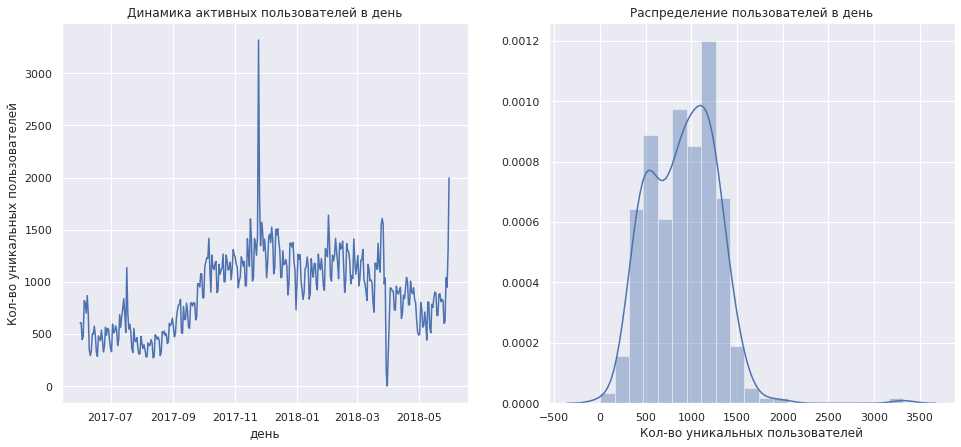

In [254]:
#посмотрим на динамику активных пользователей за день
my_plot(dau, 'date', 'день')

In [255]:
#найдем даты с минимальным и максимальным кол-вом пользователей в день
dau[(dau['n_users'] == dau['n_users'].min()) | (dau['n_users'] == dau['n_users'].max())]

,date,n_users
176,2017-11-24,3319
303,2018-03-31,1


#### В средем в день посещает сервис 921 пользователей (по медиане)
- С августа кол-во посещений в день растет, достигая максимума к началу декабря
- С февраля по май в среднем идет снижение посещений
- Максимальное кол-во посещений (3319) было 2017-11-24. Возможно, открылись продажи на какое-то массовое мероприятие или проведена акция от Яндекс.Афиша
- Минимальное кол-во посещений (1) было 2018-03-31. Скорее всего здесь какая-то ошибка. Возможно не работал сервис или ошибка данных. Нужно уточнить информацию у владельца сервиса или попробовать повторно сделать выгрузку за этот день
- Распределение похоже на бимодальное

count       53.000000
mean      5716.245283
std       2049.898027
min       2021.000000
25%       4128.000000
50%       5740.000000
75%       7401.000000
max      10586.000000
Name: n_users, dtype: float64

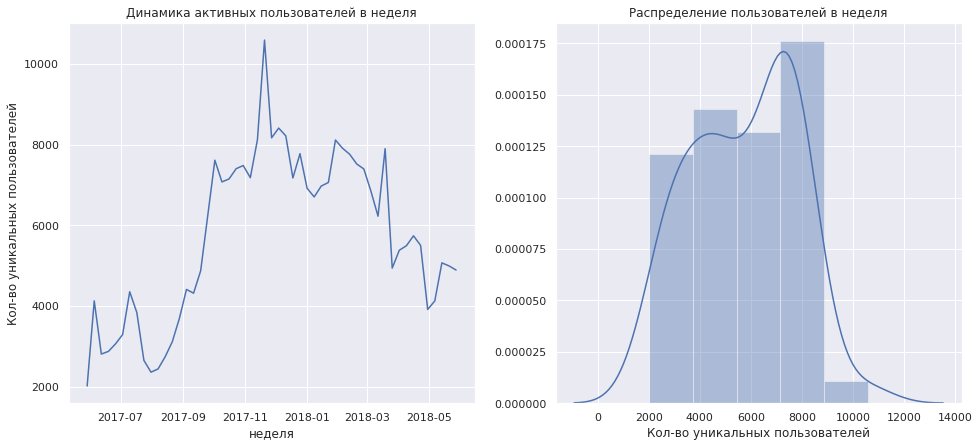

In [256]:
#посмотрим на динамику активных пользователей в неделю
my_plot(wau,'week_start','неделя')

#### В средем в неделю посещает сервис 5 740 пользователей (по медиане)
Динамика аналогична для описания активных пользователей по дням

count       12.000000
mean     23228.416667
std       7546.380462
min      11631.000000
25%      17777.000000
50%      24240.500000
75%      28984.750000
max      32797.000000
Name: n_users, dtype: float64

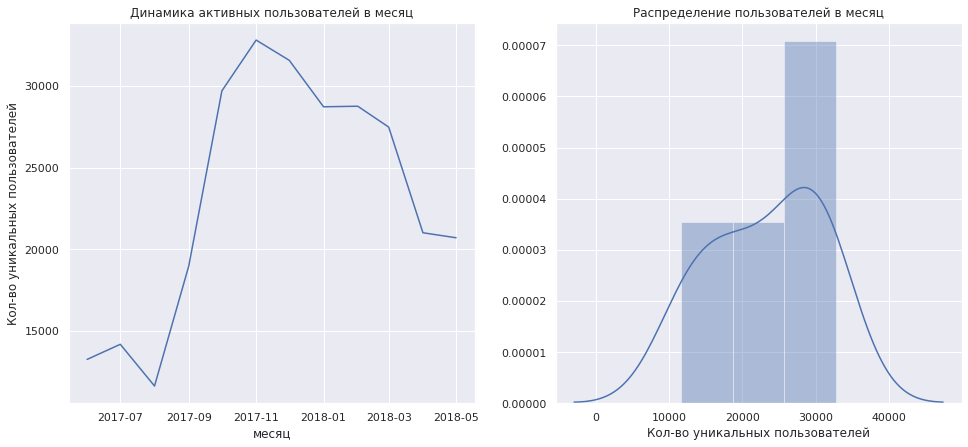

In [257]:
#посмотрим на динамику активных пользователей в месяц
my_plot(mau,'month_start','месяц')

#### В средем в месяц посещает сервис 24 240 пользователей (по медиане)
- Динамика аналогична для описания активных пользователей по дням: идет резкий рост в августе, с декабря происходит снижение
- Во всех случаях распределения имеют 2 вершины. Предположительно, что в сервис внесли существенные изменения: например, начали продавать билеты, на ранее недоступные мероприятия или расширил географию

Text(0, 0.5, 'Устройство')

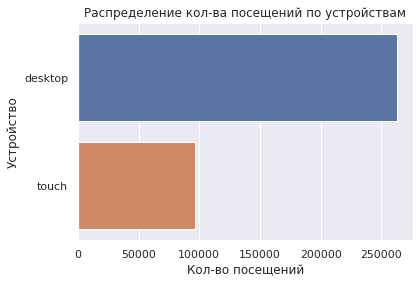

In [258]:
#посмотрим с каких устройств посещают сервис
visits_per_device = visit.groupby('device').agg({'uid':'count'}).reset_index().sort_values('uid', ascending=False)
sns.barplot(y='device',x='uid', data=visits_per_device, orient='h', order=visits_per_device['device'])
plt.title('Распределение кол-ва посещений по устройствам')
plt.xlabel('Кол-во посещений')
plt.ylabel('Устройство')

### Больше всего просмотров с ПК
- На ПК пользователи заходят в сервис в более 2 раз чаще, чем с мобильных устройств

In [259]:
#посмотрим на кол-во сессий в день
n_sessions = visit.groupby('date').agg({'start_ts':'count'}).reset_index()
n_sessions.describe()

,start_ts
count,364.000000
mean,987.362637
std,418.994796
min,1.000000
25%,635.500000
50%,1003.000000
75%,1280.000000
max,4042.000000


Text(0.5, 1.0, 'Распределение кол-во сессий в день')

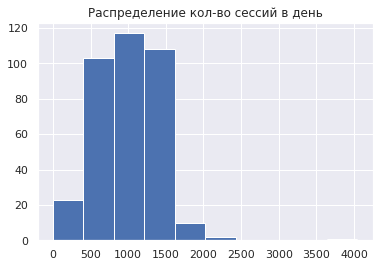

In [260]:
n_sessions.hist()
plt.title('Распределение кол-во сессий в день')

In [261]:
#посмотрим сколько сессий приходится на одного пользователя
sessions_per_user = n_sessions['start_ts'] / dau['n_users']
sessions_per_user.describe()

count    364.000000
mean       1.082170
std        0.020876
min        1.000000
25%        1.070321
50%        1.082488
75%        1.093876
max        1.217837
dtype: float64

####  В среднем (медиана) в день проходит 1003 сессий
- На каждого пользователя приходиться в среднем 1 сессия
- Распределение скошено влево

Text(0.5, 0, 'Длительность сессии, сек')

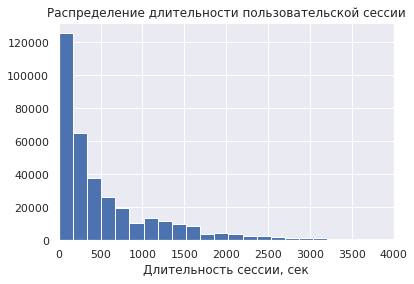

In [262]:
#посмотрим на длительность одной сессии
visit['session_duration'] = (visit['end_ts'] - visit['start_ts']).dt.seconds
visit['session_duration'].hist(bins=500)
plt.xlim(0,4000)
plt.title('Распределение длительности пользовательской сессии')
plt.xlabel('Длительность сессии, сек')

#### Распределение времени сессии не нормальное
Чтобы понять наиболее встречающиеся значения определим моду распределения, в не среднее

In [263]:
visit['session_duration'].mode()

0    60
dtype: int64

In [264]:
#разобьем пользователей на месячные когорты, чтобы исследовать их поведения

#сначала выделим месяц начала пользования сервисом
month_min = visit.groupby('uid').agg({'month_start':'min'}).reset_index()
month_min.rename(columns={'month_start':'month_start_activity'}, inplace=True)

#добавим столбец с месяцом начала пользования к общей таблице visit
visit = pd.merge(visit, month_min, on='uid')
visit.head(10)

,device,end_ts,source_id,start_ts,uid,date,week_start,month_start,session_duration,month_start_activity
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-12-20,2017-12-18,2017-12-01,1080,2017-12-01
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-02-19,2018-02-19,2018-02-01,1680,2018-02-01
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017-07-01,2017-06-26,2017-07-01,0,2017-07-01
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-05-20,2018-05-14,2018-05-01,1440,2018-03-01
4,desktop,2018-03-09 20:33:00,4,2018-03-09 20:05:00,16174680259334210214,2018-03-09,2018-03-05,2018-03-01,1680,2018-03-01
5,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017-12-27,2017-12-25,2017-12-01,0,2017-12-01
6,desktop,2017-09-03 21:36:00,5,2017-09-03 21:35:00,16007536194108375387,2017-09-03,2017-08-28,2017-09-01,60,2017-09-01
7,desktop,2017-10-27 16:02:00,3,2017-10-27 15:20:00,16007536194108375387,2017-10-27,2017-10-23,2017-10-01,2520,2017-09-01
8,desktop,2017-09-04 17:56:00,4,2017-09-04 17:37:00,16007536194108375387,2017-09-04,2017-09-04,2017-09-01,1140,2017-09-01
9,desktop,2017-10-28 00:04:00,3,2017-10-27 23:56:00,16007536194108375387,2017-10-27,2017-10-23,2017-10-01,480,2017-09-01


In [265]:
#выделим месячные периоды (life_time), чтобы в дальнейшем понять как со временем меняется кол-во пользователей в когорте
visit['lifetime'] = (visit['month_start'] - visit['month_start_activity']) / np.timedelta64(1,'M')
visit['lifetime'] = visit['lifetime'].round().astype('int')

In [266]:
visit.head(10)

,device,end_ts,source_id,start_ts,uid,date,week_start,month_start,session_duration,month_start_activity,lifetime
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-12-20,2017-12-18,2017-12-01,1080,2017-12-01,0
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-02-19,2018-02-19,2018-02-01,1680,2018-02-01,0
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017-07-01,2017-06-26,2017-07-01,0,2017-07-01,0
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-05-20,2018-05-14,2018-05-01,1440,2018-03-01,2
4,desktop,2018-03-09 20:33:00,4,2018-03-09 20:05:00,16174680259334210214,2018-03-09,2018-03-05,2018-03-01,1680,2018-03-01,0
5,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017-12-27,2017-12-25,2017-12-01,0,2017-12-01,0
6,desktop,2017-09-03 21:36:00,5,2017-09-03 21:35:00,16007536194108375387,2017-09-03,2017-08-28,2017-09-01,60,2017-09-01,0
7,desktop,2017-10-27 16:02:00,3,2017-10-27 15:20:00,16007536194108375387,2017-10-27,2017-10-23,2017-10-01,2520,2017-09-01,1
8,desktop,2017-09-04 17:56:00,4,2017-09-04 17:37:00,16007536194108375387,2017-09-04,2017-09-04,2017-09-01,1140,2017-09-01,0
9,desktop,2017-10-28 00:04:00,3,2017-10-27 23:56:00,16007536194108375387,2017-10-27,2017-10-23,2017-10-01,480,2017-09-01,1


In [267]:
#найдем кол-во уникальных пользователей в каждый период времени lifetime
cohorts = visit.groupby(['month_start_activity','lifetime']).agg({'uid':'nunique'}).reset_index()
cohorts = cohorts.rename(columns={'uid':'n_users'})

#так нас интересует разбивка когорт по месяцам,
#то поле дата начала пользования сервисом "округлим" до месяца
cohorts['month_start_activity'] = cohorts['month_start_activity'].dt.strftime('%Y-%m')
cohorts

,month_start_activity,lifetime,n_users
0,2017-06,0,13259
1,2017-06,1,1043
2,2017-06,2,713
3,2017-06,3,814
4,2017-06,4,909
...,...,...,...
73,2018-03,1,861
74,2018-03,2,557
75,2018-04,0,15709
76,2018-04,1,760


In [268]:
#найдем кол-во пользователей в когорте
initial_n_users = cohorts.query('lifetime == 0')[['month_start_activity','n_users']]

#дадим более понятное название полю с кол-вом пользователей
initial_n_users = initial_n_users.rename(columns={'n_users':'cohorts_users'})

In [269]:
#добавим к таблице с кол-вом пользователей в периоды, кол-во пользователей в когорте
cohorts = pd.merge(cohorts, initial_n_users, on='month_start_activity')

#и найдем коэффициент удержания (retention rate)
cohorts['retention'] = cohorts['n_users'] / cohorts['cohorts_users']
cohorts

,month_start_activity,lifetime,n_users,cohorts_users,retention
0,2017-06,0,13259,13259,1.000000
1,2017-06,1,1043,13259,0.078664
2,2017-06,2,713,13259,0.053775
3,2017-06,3,814,13259,0.061392
4,2017-06,4,909,13259,0.068557
...,...,...,...,...,...
73,2018-03,1,861,20589,0.041818
74,2018-03,2,557,20589,0.027053
75,2018-04,0,15709,15709,1.000000
76,2018-04,1,760,15709,0.048380


In [270]:
#сгруппируем данные по когортам
cohorts = cohorts.pivot_table(index='month_start_activity', columns='lifetime', values='retention')
cohorts.fillna('')

lifetime,0,1,2,3,4,5,6,7,8,9,10,11
month_start_activity,,,,,,,,,,,,
2017-06,1.0,0.0786635,0.0537748,0.0613923,0.0685572,0.0714232,0.0610152,0.0577721,0.0523418,0.0508334,0.0406516,0.0449506
2017-07,1.0,0.0560883,0.0512938,0.0561644,0.0582192,0.0481735,0.0453577,0.0457382,0.0388128,0.0286149,0.0274734,
2017-08,1.0,0.076908,0.0628622,0.062764,0.0500933,0.0440035,0.0363422,0.0394853,0.0278951,0.0260289,,
2017-09,1.0,0.0854885,0.069205,0.0507064,0.0393918,0.0378352,0.0358597,0.0241858,0.0228089,,,
2017-10,1.0,0.078608,0.0522385,0.0389575,0.0342611,0.0322208,0.0213651,0.0203642,,,,
2017-11,1.0,0.078281,0.0441133,0.0386817,0.0337272,0.0234146,0.0217998,,,,,
2017-12,1.0,0.0558018,0.0379927,0.0311065,0.0202628,0.0190359,,,,,,
2018-01,1.0,0.0597153,0.0393388,0.0249735,0.020244,,,,,,,
2018-02,1.0,0.0570798,0.0254539,0.0200928,,,,,,,,


Text(120.5, 0.5, 'Когорта')

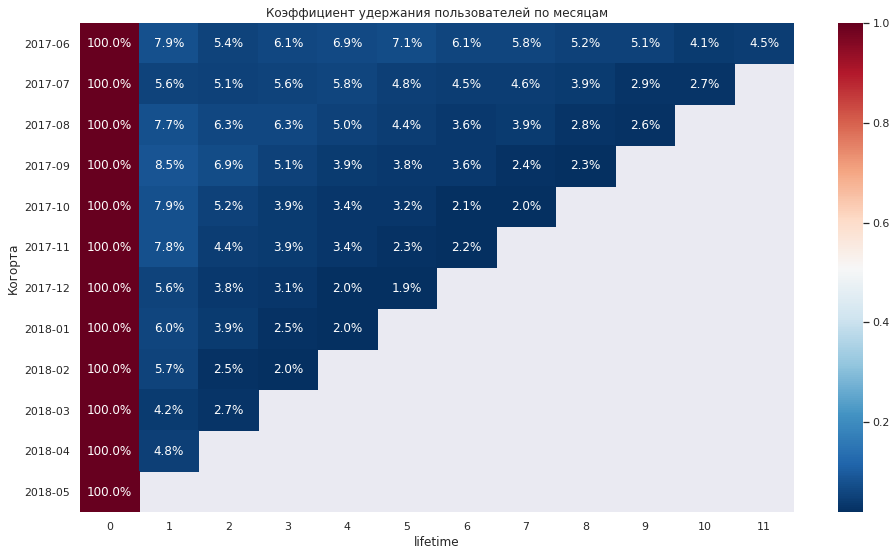

In [271]:
fig, ax1 = plt.subplots(figsize=(16,9))
sns.heatmap(cohorts, annot=True, fmt='.1%', cmap='RdBu_r')
plt.title('Коэффициент удержания пользователей по месяцам')
plt.ylabel('Когорта')

#### Больше всего пользователей возвращаются в сервис на сл.месяц после регистрации
(пояснение lifetime=0 - считаем периодом регистрации,lifetime=1 - первым месяцем пользования сервисом)
- Причем резкое снижение коэффициента удержания идет с декабрьской когорты (lifetime=1)
Reteintion rate (RT) до декабря 7.9-8.5, после - 4.2-6.0
- Снижение в первый месяц пользования в июльской когорте (RT=5.6) может объясняться сезонностью.
Летом многие уезжали в отпуска. Это подтверджается, что в июньской когорте тоже идет значительное снижение RT до 5.4
- Самой успешной можно считать июньскую когорту. Показатель RT здесь держался порядка семи периодов
- С каждой новой кортой период удержания снижается. Возможно, была выбрана неэффективная стратегия привлечения новых пользователей или снизилось качество сервиса

### 2.2. Продажи <a class="anchor" id="22"></a>

In [272]:
#посмотрим еще раз на данные по продажам
order.head()

,buy_ts,revenue,uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450


In [273]:
#выделим дату регистрации пользователя (минимальная дата начала сессии)
date_min = visit.groupby('uid').agg({'start_ts':'min'}).reset_index()
date_min = date_min.rename(columns={'start_ts':'date_start_activity'})

In [274]:
#найдем когда пользователь совершил свою первую покупку
first_purchase = order.groupby('uid').agg({'buy_ts':'min'}).reset_index()
first_purchase.rename(columns={'buy_ts':'first_order_date'}, inplace=True)

In [275]:
#объединим таблицы: дата регистрация пользователей с датой первой покупки
first_purchase = pd.merge(date_min, first_purchase, on='uid')
first_purchase.head()

,uid,date_start_activity,first_order_date
0,313578113262317,2017-09-18 22:49:00,2018-01-03 21:51:00
1,1575281904278712,2017-06-03 10:13:00,2017-06-03 10:13:00
2,2429014661409475,2017-10-11 17:14:00,2017-10-11 18:33:00
3,2464366381792757,2018-01-27 20:10:00,2018-01-28 15:54:00
4,2551852515556206,2017-11-24 10:14:00,2017-11-24 10:14:00


0      26363
1       1011
2        563
3        434
4        324
       ...  
354        1
355        3
357        4
362        1
363        1
Name: reg_buy_delta, Length: 345, dtype: int64

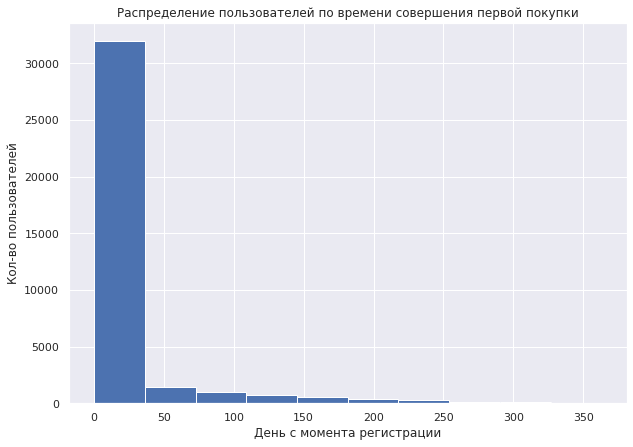

In [276]:
#найдем разницу('reg_buy_delta') в днях между датой покупки и датой регистрации
first_purchase['reg_buy_delta'] = (first_purchase['first_order_date'] - first_purchase['date_start_activity']) / np.timedelta64(1,'D')
#округлим до целых в меньшую сторону
first_purchase['reg_buy_delta'] = np.floor(first_purchase['reg_buy_delta']).astype('int')

#и посмотрим на распределение значений
first_purchase['reg_buy_delta'].hist(figsize=(10,7))
plt.title('Распределение пользователей по времени совершения первой покупки')
plt.xlabel('День с момента регистрации')
plt.ylabel('Кол-во пользователей')
first_purchase['reg_buy_delta'].value_counts().sort_index()

#### В основном пользователи совершают покупку в первый день регистрации (в течение 24 часов)
- Или скорее всего регистрируются, чтобы купить определенный билет (когда знают уже куда сходить)
- Хотя встречаются и такие, которые соверщают покупки даже через год с момента регистрации

In [277]:
#посмотрим, сколько покупок делают за период
#разобьем на месячные когорты

#сохраним перевоначальные данные заказов, так они потом пригодятся
order_org = order.copy()

order = pd.merge(order, first_purchase[['first_order_date', 'uid']] , on='uid')

In [278]:
#в столбцах с датами "округлим" до месяца
order['buy_ts'] = order['buy_ts'].astype('datetime64[M]')
order['first_order_date'] = order['first_order_date'].astype('datetime64[M]')
order

,buy_ts,revenue,uid,first_order_date
0,2017-06-01,17.00,10329302124590727494,2017-06-01
1,2017-06-01,0.55,11627257723692907447,2017-06-01
2,2017-06-01,0.37,17903680561304213844,2017-06-01
3,2017-06-01,0.55,16109239769442553005,2017-06-01
4,2017-06-01,0.37,14200605875248379450,2017-06-01
...,...,...,...,...
50410,2018-05-01,4.64,12296626599487328624,2018-05-01
50411,2018-05-01,5.80,11369640365507475976,2018-05-01
50412,2018-05-01,0.30,1786462140797698849,2018-05-01
50413,2018-05-01,3.67,3993697860786194247,2018-05-01


In [279]:
#посчитаем сколько покупок совершают в месяц
purchase = order.groupby('buy_ts').agg({'uid': 'count', 'revenue':'sum'}).reset_index()
purchase.columns = ['buy_month', 'n_purchases', 'revenue_month']
purchase

,buy_month,n_purchases,revenue_month
0,2017-06-01,2354,9557.49
1,2017-07-01,2363,12539.47
2,2017-08-01,1807,8758.78
3,2017-09-01,3387,18345.51
4,2017-10-01,5679,27987.70
5,2017-11-01,5659,27069.93
6,2017-12-01,6218,36388.60
7,2018-01-01,4721,19417.13
8,2018-02-01,5281,25560.54
9,2018-03-01,5326,28834.59


In [280]:
#так как мы считаем за год, то уберем последнюю покупку
purchase.drop(12, inplace=True)

#посмотрим характерные значения кол-ва покупок
purchase['n_purchases'].describe()

count      12.000000
mean     4201.166667
std      1511.972092
min      1807.000000
25%      3045.500000
50%      4533.500000
75%      5409.250000
max      6218.000000
Name: n_purchases, dtype: float64

#### В среднем за месяц совершается 4 200 покупок

<div style="border:solid gold 2px; padding: 20px"> <h1 style="color:gold; margin-bottom:20px">Комментарий наставника</h1>

Хорошо, но здесь стоило посмотреть количество покупок на одного пользователя. Здесь весь анализ идет в рассчете на одного пользователя.

In [281]:
purchase['avg_ticket'] = purchase['revenue_month'] / purchase['n_purchases']
purchase['avg_ticket'].describe()

count    12.000000
mean      4.956925
std       0.521265
min       4.060106
25%       4.780459
50%       4.887709
75%       5.333424
max       5.852139
Name: avg_ticket, dtype: float64

#### Средний чек составляет 5.0 единиц

In [282]:
#LTV будем считать по когортам (месяцу первой покупки)
#сначала создадим эти когорты и подсчитаем, сколько денег приносят пользователи когорты по месяцам
cohort_order = order.groupby(['first_order_date','buy_ts']).agg({'revenue':'sum'}).reset_index()
cohort_order

,first_order_date,buy_ts,revenue
0,2017-06-01,2017-06-01,9557.49
1,2017-06-01,2017-07-01,981.82
2,2017-06-01,2017-08-01,885.34
3,2017-06-01,2017-09-01,1931.30
4,2017-06-01,2017-10-01,2068.58
...,...,...,...
74,2018-03-01,2018-05-01,1114.87
75,2018-04-01,2018-04-01,10600.69
76,2018-04-01,2018-05-01,1209.92
77,2018-05-01,2018-05-01,13925.76


In [283]:
#подсчитаем сколько покупателей в когорте и добавим эти данные в таблицу с когортой ('cohort_order')
cohort_size = order.groupby('first_order_date').agg({'uid': 'nunique'}).reset_index()
cohort_size.columns = ['first_order_date', 'n_buyer']

cohort_order = pd.merge(cohort_order, cohort_size, on='first_order_date')
cohort_order

,first_order_date,buy_ts,revenue,n_buyer
0,2017-06-01,2017-06-01,9557.49,2023
1,2017-06-01,2017-07-01,981.82,2023
2,2017-06-01,2017-08-01,885.34,2023
3,2017-06-01,2017-09-01,1931.30,2023
4,2017-06-01,2017-10-01,2068.58,2023
...,...,...,...,...
74,2018-03-01,2018-05-01,1114.87,3533
75,2018-04-01,2018-04-01,10600.69,2276
76,2018-04-01,2018-05-01,1209.92,2276
77,2018-05-01,2018-05-01,13925.76,2988


In [284]:
#посчитаем сколько в среднем приносит покупатель когорты
cohort_order['ltv'] = cohort_order['revenue'] /  cohort_order['n_buyer']

In [285]:
#вместо месяца покупки когорты ('buy_ts'), разобьем на порядок месяца повторных покупок
cohort_order['age'] = (cohort_order['buy_ts'] - cohort_order['first_order_date']) / np.timedelta64(1, 'M')
cohort_order['age'] = cohort_order['age'].round().astype('int')

cohort_order

,first_order_date,buy_ts,revenue,n_buyer,ltv,age
0,2017-06-01,2017-06-01,9557.49,2023,4.724414,0
1,2017-06-01,2017-07-01,981.82,2023,0.485329,1
2,2017-06-01,2017-08-01,885.34,2023,0.437637,2
3,2017-06-01,2017-09-01,1931.30,2023,0.954671,3
4,2017-06-01,2017-10-01,2068.58,2023,1.022531,4
...,...,...,...,...,...,...
74,2018-03-01,2018-05-01,1114.87,3533,0.315559,2
75,2018-04-01,2018-04-01,10600.69,2276,4.657597,0
76,2018-04-01,2018-05-01,1209.92,2276,0.531599,1
77,2018-05-01,2018-05-01,13925.76,2988,4.660562,0


Text(120.49999999999999, 0.5, 'Когорта')

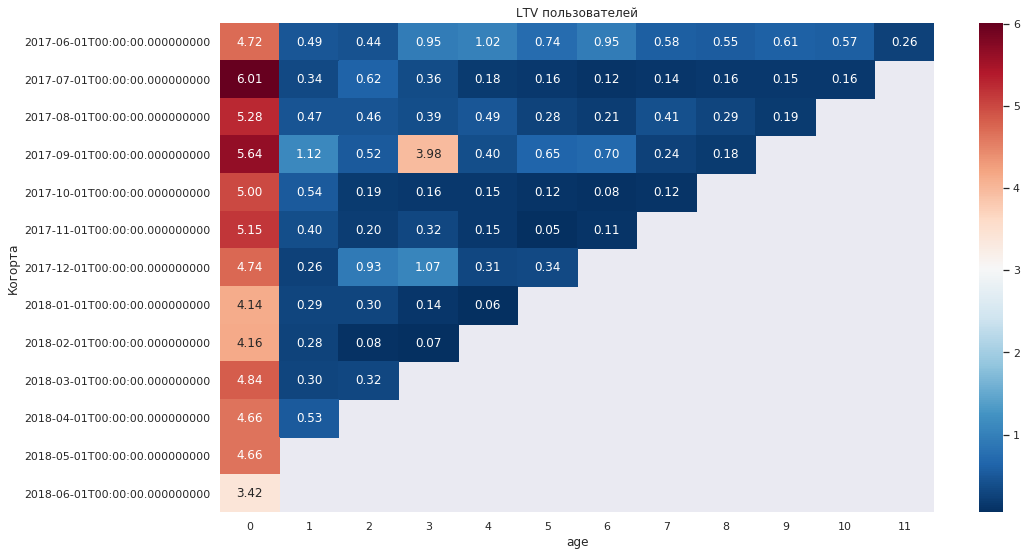

In [286]:
result = cohort_order.pivot_table(index='first_order_date',
                                  columns='age',
                                  values='ltv',
                                  aggfunc='mean'
                                    )
result.fillna('')

fig, ax1 = plt.subplots(figsize=(16,9))
sns.heatmap(result, annot=True, fmt='.2f', cmap='RdBu_r')
plt.title('LTV пользователей')
plt.ylabel('Период, мес.')
plt.ylabel('Когорта')

In [287]:
#посмотрим сколько принесла за год первая когорта
ltv_201706 = result.loc['2017-06-01'].sum()
ltv_201706

11.879233811171527

#### Больше всего средняя выручка с пользователя идет в первый месяц покупки
- Со следующего месяца идет резкое снижение прибыли
- Больше всего денег дают пользователи когорты 2017-07, 2017-08, 2017-09: 6.01, 5.28, 5.64, соответственно
- Первая когорта за год принесла 11.9 единиц выручки


### 2.3. Маркетинг <a class="anchor" id="23"></a>

In [288]:
#вспомним таблицу с расходами на маркетинг
cost.head()

,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08


In [289]:
#расходы даются по дням
#чтобы посчитать месячные расходы, сначала добавим поле с месяцем
cost['dt_month'] = cost['dt'].astype('datetime64[M]')

#и сделаем сводную таблицу с суммарными расходами за месяц
monthly_cost = cost.groupby('dt_month').agg({'costs':'sum'}).reset_index()
monthly_cost

,dt_month,costs
0,2017-06-01,18015.00
1,2017-07-01,18240.59
2,2017-08-01,14790.54
3,2017-09-01,24368.91
4,2017-10-01,36322.88
5,2017-11-01,37907.88
6,2017-12-01,38315.35
7,2018-01-01,33518.52
8,2018-02-01,32723.03
9,2018-03-01,30415.27


In [290]:
monthly_cost.describe()

,costs
count,12.000000
mean,27427.635000
std,8405.071207
min,14790.540000
25%,21228.350000
50%,27392.090000
75%,34219.610000
max,38315.350000


In [291]:
#общая сумма расходов на маркетинг
monthly_cost['costs'].sum()

329131.61999999994

#### Расходы на маркетинг росли с января до июня
- С июля 2017 расходы стали сокращаться
- Наибольшие расходы на маркетинг были с октября по февраль
- В среднем в месяц расходуется 27 000 единиц
- За год было на маркетинг было потрачено около 329 000 единиц

In [292]:
#посмотрим, сколько денег тратиться на каждый источник
cost_per_source = (cost
                   .groupby('source_id')
                   .agg({'costs':'sum'})
                   .reset_index()
                   .sort_values('costs', ascending=False)
                  )
cost_per_source

,source_id,costs
2,3,141321.63
3,4,61073.60
4,5,51757.10
1,2,42806.04
0,1,20833.27
6,10,5822.49
5,9,5517.49


Text(0, 0.5, 'Источник')

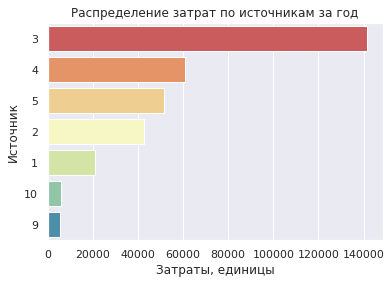

In [293]:
sns.barplot(y='source_id',x='costs', data=cost_per_source, orient='h', order=cost_per_source['source_id'], palette='Spectral')
plt.title('Распределение затрат по источникам за год')
plt.xlabel('Затраты, единицы')
plt.ylabel('Источник')

#### Около 40% маркетингого бюджета пошло на источник №3
- Меньше всего денег тратиться на источники №9 и №10

### Расчет LTV, CAC, ROMI для различных устройств и источников <a class="anchor" id="231"></a>

In [294]:
#добавим поле с датой заказа (без времени)
order_org['buy_ts_date'] = order_org['buy_ts'].astype('datetime64[D]')
order_org

,buy_ts,revenue,uid,buy_ts_date
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01
...,...,...,...,...
50410,2018-05-31 23:50:00,4.64,12296626599487328624,2018-05-31
50411,2018-05-31 23:50:00,5.80,11369640365507475976,2018-05-31
50412,2018-05-31 23:54:00,0.30,1786462140797698849,2018-05-31
50413,2018-05-31 23:56:00,3.67,3993697860786194247,2018-05-31


In [295]:
#выделим из визитов тех пользователей, у которых есть заказы
#и найдем их первую дату заказа и источник, откуда пришли
paying_users = (visit[visit['uid'].isin(order_org['uid'].unique())]
               .sort_values(by=['uid','date'])
               .groupby('uid')
               .agg({'date':'first','source_id':'first', 'device':'first'})
               .rename(columns={'date':'acquisition_ts'})
               .reset_index())

#добавим столбец со стоимостью привлечения в этот месяц, в зависимости от источника
paying_users = pd.merge(paying_users, cost, left_on=['acquisition_ts','source_id'], right_on=['dt','source_id'], how='left')
paying_users

,uid,acquisition_ts,source_id,device,dt,costs,dt_month
0,313578113262317,2017-09-18,2,desktop,2017-09-18,103.36,2017-09-01
1,1575281904278712,2017-06-03,10,touch,2017-06-03,9.62,2017-06-01
2,2429014661409475,2017-10-11,3,desktop,2017-10-11,433.84,2017-10-01
3,2464366381792757,2018-01-27,5,desktop,2018-01-27,152.74,2018-01-01
4,2551852515556206,2017-11-24,5,desktop,2017-11-24,719.22,2017-11-01
...,...,...,...,...,...,...,...
36518,18445147675727495770,2017-08-20,5,touch,2017-08-20,54.85,2017-08-01
36519,18445407535914413204,2017-09-22,3,desktop,2017-09-22,281.40,2017-09-01
36520,18445601152732270159,2017-08-07,2,desktop,2017-08-07,32.72,2017-08-01
36521,18446156210226471712,2017-11-07,3,desktop,2017-11-07,472.89,2017-11-01


In [296]:
#найдем сколько пользователей в день впервые сделали заказ
user_cost = (paying_users
             .groupby(['acquisition_ts','source_id'])
             .agg({'device':'count', 'costs':'mean'})
             .reset_index()
             .rename(columns={'device':'n_users'})
            )

#посчитаем сколько стоит привлечение одного пользователя по источникам
user_cost['acquisition_cost'] = user_cost['costs'] / user_cost['n_users']
user_cost

,acquisition_ts,source_id,n_users,costs,acquisition_cost
0,2017-06-01,1,25,75.20,3.008000
1,2017-06-01,2,30,132.56,4.418667
2,2017-06-01,3,43,349.38,8.125116
3,2017-06-01,4,31,76.74,2.475484
4,2017-06-01,5,23,73.24,3.184348
...,...,...,...,...,...
2391,2018-05-31,3,64,822.30,12.848438
2392,2018-05-31,4,53,492.54,9.293208
2393,2018-05-31,5,23,398.04,17.306087
2394,2018-05-31,9,1,27.37,27.370000


In [297]:
#добавим столбец со стоимостью привлечения к таблице c пользователям с заказами
paying_users = pd.merge(paying_users, user_cost[['acquisition_ts', 'source_id', 'acquisition_cost']],
                        left_on=['acquisition_ts', 'source_id'],
                        right_on=['acquisition_ts', 'source_id'],
                        how='left')[['uid', 'acquisition_ts', 'source_id', 'device', 'acquisition_cost']]
paying_users

,uid,acquisition_ts,source_id,device,acquisition_cost
0,313578113262317,2017-09-18,2,desktop,6.890667
1,1575281904278712,2017-06-03,10,touch,1.374286
2,2429014661409475,2017-10-11,3,desktop,8.853878
3,2464366381792757,2018-01-27,5,desktop,8.038947
4,2551852515556206,2017-11-24,5,desktop,16.345909
...,...,...,...,...,...
36518,18445147675727495770,2017-08-20,5,touch,3.917857
36519,18445407535914413204,2017-09-22,3,desktop,8.527273
36520,18445601152732270159,2017-08-07,2,desktop,6.544000
36521,18446156210226471712,2017-11-07,3,desktop,19.703750


In [298]:
#найдем, сколько всего потратили пользователи
order_total = (order_org
               .groupby('uid').agg({'revenue':'sum'})
               .rename(columns={'revenue':'revenue_total'})
               .reset_index()) 

In [299]:
order_cost = pd.merge(paying_users, order_total, on='uid', how='left')
order_cost

,uid,acquisition_ts,source_id,device,acquisition_cost,revenue_total
0,313578113262317,2017-09-18,2,desktop,6.890667,0.55
1,1575281904278712,2017-06-03,10,touch,1.374286,3.05
2,2429014661409475,2017-10-11,3,desktop,8.853878,73.33
3,2464366381792757,2018-01-27,5,desktop,8.038947,2.44
4,2551852515556206,2017-11-24,5,desktop,16.345909,10.99
...,...,...,...,...,...,...
36518,18445147675727495770,2017-08-20,5,touch,3.917857,3.05
36519,18445407535914413204,2017-09-22,3,desktop,8.527273,0.88
36520,18445601152732270159,2017-08-07,2,desktop,6.544000,4.22
36521,18446156210226471712,2017-11-07,3,desktop,19.703750,9.78


In [300]:
#посчитаем ROMI
order_cost['romi'] = order_cost['revenue_total'] / order_cost['acquisition_cost']
order_cost

,uid,acquisition_ts,source_id,device,acquisition_cost,revenue_total,romi
0,313578113262317,2017-09-18,2,desktop,6.890667,0.55,0.079818
1,1575281904278712,2017-06-03,10,touch,1.374286,3.05,2.219335
2,2429014661409475,2017-10-11,3,desktop,8.853878,73.33,8.282247
3,2464366381792757,2018-01-27,5,desktop,8.038947,2.44,0.303522
4,2551852515556206,2017-11-24,5,desktop,16.345909,10.99,0.672339
...,...,...,...,...,...,...,...
36518,18445147675727495770,2017-08-20,5,touch,3.917857,3.05,0.778487
36519,18445407535914413204,2017-09-22,3,desktop,8.527273,0.88,0.103198
36520,18445601152732270159,2017-08-07,2,desktop,6.544000,4.22,0.644866
36521,18446156210226471712,2017-11-07,3,desktop,19.703750,9.78,0.496352


Text(0, 0.5, 'Источник')

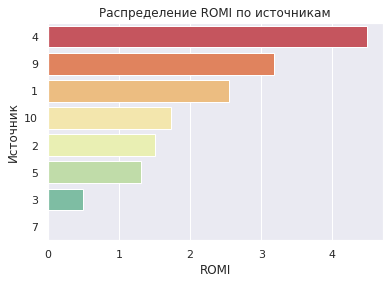

In [301]:
#посмотрим у какого источник выше окупаемость
romi_per_source = order_cost.groupby('source_id').agg({'romi':'mean'}).reset_index().sort_values('romi', ascending=False)
sns.barplot(y='source_id',x='romi', data=romi_per_source, orient='h', order=romi_per_source['source_id'], palette='Spectral')
plt.title('Распределение ROMI по источникам')
plt.xlabel('ROMI')
plt.ylabel('Источник')

#### Наиболее выгоднее вкладываться в маркетинг источника №4, №9 и №1
- Как видели ранее, источник №4 стоит на втором месте по объему затрат. То есть оправдан фокус внимания маркетологов на этот источник
- А вот источник №3 находится последнем месте по ROMI, однако на него больше всего(>40%) было потрачено годового маркетингого бюджета

Text(0, 0.5, 'Устройство')

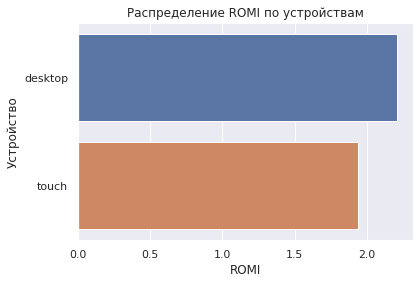

In [302]:
#посмотрим у какой платформы выше окупаемость
romi_per_device = order_cost.groupby('device').agg({'romi':'mean'}).reset_index().sort_values('romi', ascending=False)
sns.barplot(y='device',x='romi', data=romi_per_device, orient='h', order=romi_per_device['device'])
plt.title('Распределение ROMI по устройствам')
plt.xlabel('ROMI')
plt.ylabel('Устройство')

### Маркетинговы затраты выгоднее вкладывать в пользователей на ПК, чем в пользователей на мобильных устройствах
- Хотя принципиального различия нет

<div style="border:solid green 2px; padding: 20px"> <h1 style="color:green; margin-bottom:20px">Комментарий наставника</h1>

Отличный маркетинговый анализ

### 3.  Выводы <a class="anchor" id="3"></a>

- В исследовании были использованы данных из 3х таблиц: визиты(visit),заказы(order), маркетинговые затраты(cost)
- Данные чистые: нет пропусков, дубликатов
- Самая большая таблица с визитами: 359400 записей

- В средем в день посещает сервис 921 пользователей (по медиане)
- С августа кол-во посещений в день растет, достигая максимума к началу декабря
- С февраля по май в среднем идет снижение посещений
- Максимальное кол-во посещений (3319) было 2017-11-24. Возможно, открылись продажи на какое-то массовое мероприятие или проведена акция от Яндекс.Афиша
- Минимальное кол-во посещений (1) было 2018-03-31. Скорее всего здесь какая-то ошибка. Возможно не работал сервис или ошибка данных. Нужно уточнить информацию у владельца сервиса или попробовать повторно сделать выгрузку за этот день
- В средем в неделю посещает сервис 5 740 пользователей, в месяц - 24 240 пользователей (по медиане)
- На каждого пользователя в день приходиться в среднем 1 сессия, ее длительность составляет 60 секунд
- Больше всего пользователей возвращаются в сервис на сл.месяц после регистрации
- Причем резкое снижение коэффициента удержания идет с декабрьской когорты (lifetime=1)
- Самой успешной можно считать июньскую когорту. Показатель RT здесь держался порядка семи периодов
- С каждой новой кортой период удержания снижается. Возможно, была выбрана неэффективная стратегия привлечения новых пользователей или снизилось качество сервиса
- Средний чек составляет 5.0 единиц
- Пользователи совершают покупку в течение 24 часов после регистрации
- Расходы на маркетинг росли с января до июня
- Около 40% маркетингого бюджета пошло на источник №3
- Меньше всего денег тратиться на источники №9 и №10
- Наиболее выгоднее вкладываться в маркетинг источника №4, №9 и №1
- Как видели ранее, источник №4 стоит на втором месте по объему затрат. То есть оправдан фокус внимания маркетологов на этот источник
- А вот источник №3 находится последнем месте по ROMI, однако на него больше всего(>40%) было потрачено годового маркетингого

<b>Рекомендация отделу маркетинга</b>
- На будующий год распределить большую часть бюджета на источники  №4, №9 и №1
- Отказаться от источника №3
- Лучше ориентироваться на пользователей и ПК, и мобильных устройств

<div style="border:solid green 2px; padding: 20px"> <h1 style="color:green; margin-bottom:20px">Комментарий наставника</h1>

Хорошо, конкретные рекомендации - это верно.